<h1 style="font-family: 'American Typewriter', sans-serif"> <b>
    Análisis de patrones de desigualdad de ingresos
</b> </h1>

<p style="font-family: 'Brush Script MT', cursive; font-size: 24px;" align="right">
Francisco Chaux Guzmán
</p>

# Preparación del entorno de trabajo

Se hace la carga de las librerías necesarias.

In [40]:
# procesamiento de datos
import numpy as np
import pandas as pd

# visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# aprendizaje de máquinas

from sklearn.preprocessing import StandardScaler

# Preparación de los datos

Se realiza la importación de la [información mundial sobre desigualdad de ingresos](https://www.kaggle.com/datasets/mannmann2/world-income-inequality-database).

In [41]:
# lectura de los datos
datos_desigualdad = pd.read_csv('../datos/WIID_06MAY2020.csv')
# revisión de las primeras observaciones
datos_desigualdad.head()

,Unnamed: 0,id,country,c3,c2,year,gini_reported,palma,ratio_top20bottom20,bottom40,...,gdp_ppp_pc_usd2011,population,revision,quality,quality_score,source,source_detailed,source_comments,survey,link
0,0,1,Afghanistan,AFG,AF,2008,29.00,NaN,4.33,22.00,...,1268.0,27722282.0,New 2019,High,12,National statistical authority,European Union and the Central Statistics Orga...,NaN,Living Conditions Survey (LCS),https://cso-of-afghanistan.shinyapps.io/ALCS_D...
1,1,2,Afghanistan,AFG,AF,2012,33.00,NaN,4.11,23.00,...,1773.0,31161378.0,New 2019,High,12,National statistical authority,European Union and the Central Statistics Orga...,NaN,Living Conditions Survey (LCS),https://cso-of-afghanistan.shinyapps.io/ALCS_D...
2,2,3,Afghanistan,AFG,AF,2017,31.00,NaN,4.44,22.00,...,1758.0,36296108.0,New 2019,High,12,National statistical authority,European Union and the Central Statistics Orga...,NaN,Living Conditions Survey (LCS),https://eeas.europa.eu/regions/asia/44072/resu...
3,3,4,Albania,ALB,AL,1996,27.01,0.93,3.95,22.85,...,4635.0,3098699.0,New 2019,Average,13,World Bank,World Bank 2019,PovcalNet,NaN,http://iresearch.worldbank.org/PovcalNet/povOn...
4,4,5,Albania,ALB,AL,2002,31.74,1.22,4.83,20.93,...,6088.0,3126183.0,New 2019,Average,13,World Bank,World Bank 2019,PovcalNet,NaN,http://iresearch.worldbank.org/PovcalNet/povOn...


También se revisa la estructura general de la base. Debido a que son muchas variables, por el momento se excluye su listado (con `verbose=False`) y, en su lugar, se seleccionan las variables que se van a utilizar (para esto se usa el [diccionario](https://www.wider.unu.edu/sites/default/files/WIID/PDF/WIID-User_Guide_06MAY2020.pdf)) y se revisan con mayor profundidad.

In [42]:
datos_desigualdad.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11826 entries, 0 to 11825
Columns: 60 entries, Unnamed: 0 to link
dtypes: float64(28), int64(4), object(28)
memory usage: 5.4+ MB


Se tienen 11,826 observaciones y 60 variables, de las cuales 28 son numéricas continuas, 4 son númericas enteras y 28 son de tipo texto.

Con base en el diccionario, se seleccionan las siguientes variables para su análisis:

- `id`. Identificador.
- `country`. País o área.
-  `year`. Año. En este caso, cuando una encuesta se prolonga durante más de un año, se considera
el año en que finaliza.
- `gini_reported`. El coeficiente de Gini tal y como es reportado por la fuente.
- `palma`. La razón de Palma.
- `incomegroup`. Clasificación del país según su clasificación de ingreso en el Banco Mundial.
- `population`. Población del país, de acuerdo a proyecciones de la ONU.

In [43]:
datos_desigualdad = datos_desigualdad[[
    'id', 'country', 'year', 'gini_reported', 'palma', 'incomegroup', 'population'
    ]]

Hecha la selección, se vuelve a revisar la estructura.

In [44]:
datos_desigualdad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11826 entries, 0 to 11825
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             11826 non-null  int64  
 1   country        11826 non-null  object 
 2   year           11826 non-null  int64  
 3   gini_reported  11747 non-null  float64
 4   palma          6714 non-null   float64
 5   incomegroup    11826 non-null  object 
 6   population     11765 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 646.9+ KB


Lo primero que se nota es la presencia de varies faltantes en el coeficiente de Gini, la razón de Palma y la población.

Debido a que los análisis se sentrarán en el coeficiente de Gini, se eliminan los faltantes en esa variable y se revisa cómo queda.

In [45]:
datos_desigualdad = datos_desigualdad.dropna(subset=['gini_reported'])
datos_desigualdad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11747 entries, 0 to 11825
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             11747 non-null  int64  
 1   country        11747 non-null  object 
 2   year           11747 non-null  int64  
 3   gini_reported  11747 non-null  float64
 4   palma          6676 non-null   float64
 5   incomegroup    11747 non-null  object 
 6   population     11686 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 734.2+ KB


Ya no hay faltantes en las variables. Se dejan los otros faltantes para no perder tanta información.

Ahora, se revisa la presencia de observaciones duplicadas.

In [46]:
if datos_desigualdad.duplicated().any()==False:
    print("No hay observaciones duplicadas")
else:
    print("Hay observaciones duplicadas")

No hay observaciones duplicadas


Por otra parte, se revisa el comportamiento de las variables numéricas.

In [47]:
datos_desigualdad.describe().style.format("{:,.2f}")

,id,year,gini_reported,palma,population
count,"11,747.00","11,747.00","11,747.00","6,676.00","11,686.00"
mean,"5,914.49","1,996.01",38.23,2.18,"78,849,194.14"
std,"3,407.60",15.85,10.20,1.65,"211,861,346.94"
min,1.00,"1,867.00",12.10,0.55,"10,521.00"
25%,"2,970.50","1,988.00",30.30,1.15,"5,244,036.00"
50%,"5,913.00","1,999.00",36.48,1.61,"15,262,754.00"
75%,"8,862.50","2,009.00",46.00,2.81,"56,542,434.00"
max,"11,826.00","2,018.00",78.60,39.81,"1,421,021,696.00"


Es de notar que variables como el Gini no aparecen en el formato correcto, ya que debería ser menor a cero y estar a tres digitos. Se corrige con la siguiente línea.

In [48]:
datos_desigualdad['gini_reported'] = datos_desigualdad['gini_reported'] / 100
datos_desigualdad['gini_reported'].describe()

count    11747.000000
mean         0.382326
std          0.102028
min          0.121000
25%          0.303000
50%          0.364800
75%          0.460000
max          0.786000
Name: gini_reported, dtype: float64

De esta forma, se proceden a los análisis siguientes.

# Visualizaciones

## Distribución de los coeficientes de Gini

Se inicia revisando la distribución del valor del coeficiente de Gini. La concentración es alta entre 0.3 y 0.4, con una censura general hacia la izquierda de la distribución. Esto parece significar que, en general, no se presentan valores tan altos como los que podrían pensarse en principio.

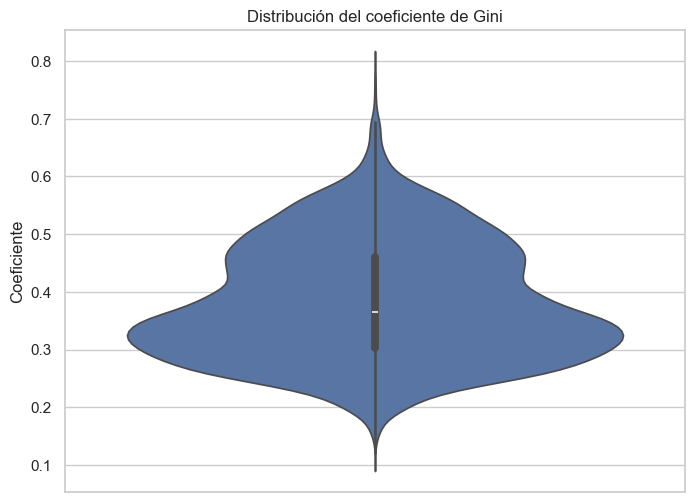

In [49]:
# creación del espacio para el gráfico

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# generación del gráfico

sns.violinplot(data=datos_desigualdad, y='gini_reported')

# títulos y etiquetas

plt.title('Distribución del coeficiente de Gini')
plt.xlabel('')
plt.ylabel('Coeficiente')

# impresión del gráfico
plt.show()

Al revisar la distribución por grupo de ingresos, se ven algunas diferencias. Los países de ingreso alto tienen a tener valores de Gini más bajos, con una concentración más cercana a 0.3. Los valores más altos se evidencian en los países de ingreso medio alto, cercanos al 0.5. Le siguen los países de ingreso bajo y, cerca a los países de ingreso alto, aquellos de ingreso medio bajo.

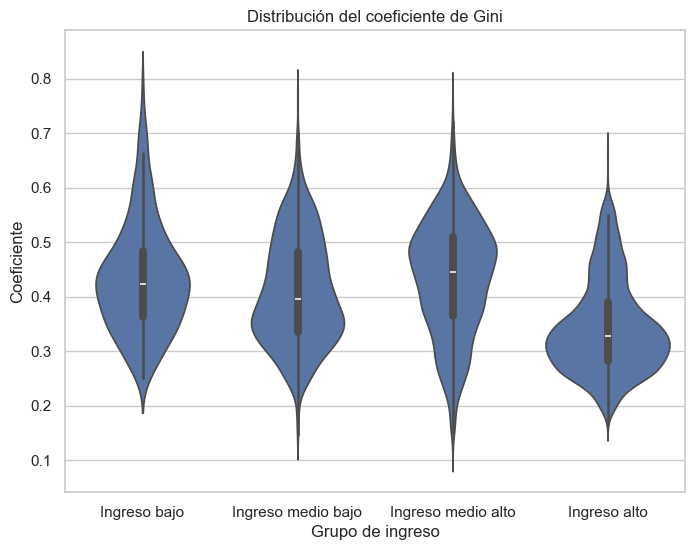

In [50]:
# creación de grupos de ingreso en español

dict_grupoingreso = {
    'Low income': 'Ingreso bajo',
    'Lower middle income': 'Ingreso medio bajo',
    'Upper middle income': 'Ingreso medio alto',
    'High income': 'Ingreso alto'
}
datos_desigualdad['grupoingreso'] = datos_desigualdad['incomegroup'].map(dict_grupoingreso)

# definición de orden de las categorías

orden_categorias = [
    'Ingreso bajo',
    'Ingreso medio bajo',
    'Ingreso medio alto',
    'Ingreso alto'
]

# creación del espacio para el gráfico

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# generación del gráfico

sns.violinplot(data=datos_desigualdad, x = 'grupoingreso', y='gini_reported', order=orden_categorias)

# títulos y etiquetas

plt.title('Distribución del coeficiente de Gini')
plt.xlabel('Grupo de ingreso')
plt.ylabel('Coeficiente')

# impresión del gráfico
plt.show()

## Distribución de las razones de Palma

Se revisa la distribución de la razón de Palma. En este caso, la distribución es aún menos desigual, lo que dificulta su visualización mediante el diagrama de violín. Esto se debe a la presencia de múltiples valores atípicos, por lo que también se incluye el diagrama de caja. La mayoría de los valores se sitúa entre 0 y 5, lo que significa que el decil superior de ingresos percibe hasta cinco veces la suma de los ingresos de los cuatro deciles inferiores.

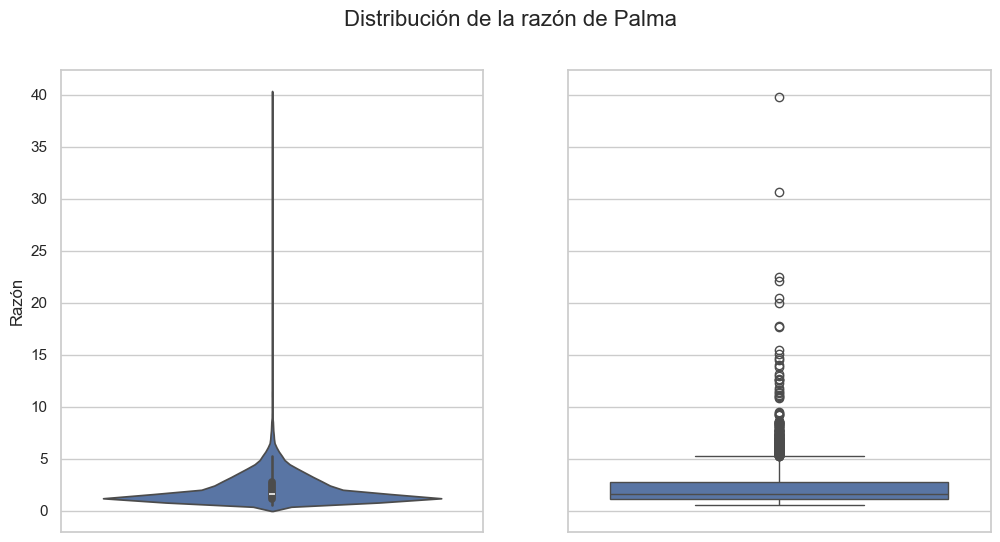

In [51]:
# creación del espacio para el gráfico

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# gráfico de violín en el primer eje
sns.violinplot(data=datos_desigualdad, y='palma', ax=ax1, inner="box")
ax1.set_xlabel('')
ax1.set_ylabel('Razón')

# gráfico de caja en el segundo eje
sns.boxplot(data=datos_desigualdad, y='palma', ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')

# título general
plt.suptitle('Distribución de la razón de Palma', fontsize=16)

# impresión del gráfico
plt.show()

Al revisar la distribución por grupo de ingresos, se ven diferencias notables. Parece que los países de ingreso bajo son los que tienen los valores más altos, con más valores atípicos, lo que explica porque la distribución general es tan desigual. Los países de ingreso alto tiene los valores más bajos, mientras que los de ingreso medio tiene los valores más intermedios.

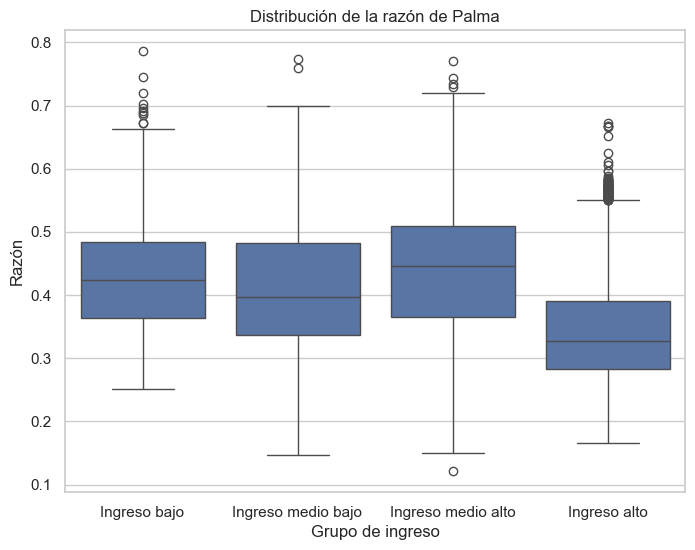

In [52]:
# creación del espacio para el gráfico

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# generación del gráfico

sns.boxplot(data=datos_desigualdad, x = 'grupoingreso', y='gini_reported', order=orden_categorias)

# títulos y etiquetas

plt.title('Distribución de la razón de Palma')
plt.xlabel('Grupo de ingreso')
plt.ylabel('Razón')

# impresión del gráfico
plt.show()

# Coeficiente de Gini y razón de Palma comparados

Se comparan las distribuciones del coeficiente de Gini y la razón de Palma. Debido a que las escalas de ambos son muy diferentes, se utilizan dos aproximaciones alternativas:
- Escalar las variables y compararlas con diagramas de cajas.
- Ver la relación en un diagrama de puntos.

Primero, se grafican los diagramas de caja. Se observa que el coeficiente de Gini tiene una variabilidad más pequeña que el de la razón de Palma. Es evidente que esto se debe a que la desigualdad es más marcada en los extremos de los deciles, que es justo lo que mide la razón de Palma.

Text(0, 0.5, 'Valor')

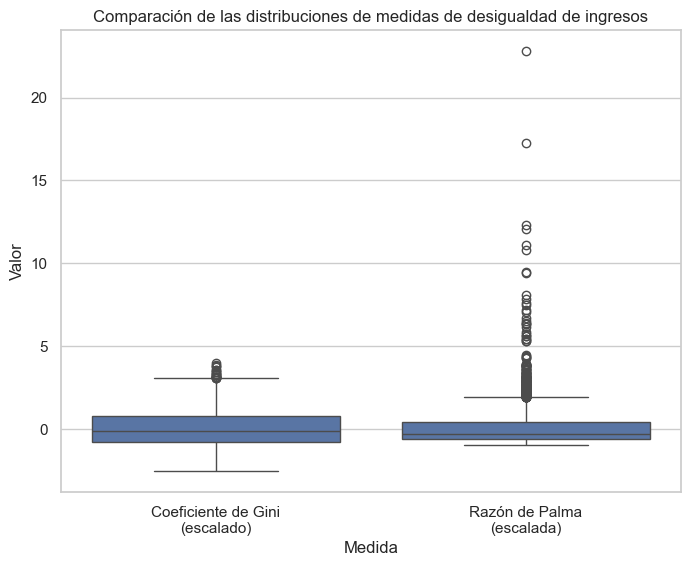

In [53]:
# creación del espacio para el gráfico

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# generación de valores escalados

datos_desigualdad[['Coeficiente de Gini\n(escalado)', 'Razón de Palma\n(escalada)']] = StandardScaler().fit_transform(
    datos_desigualdad[['gini_reported', 'palma']]
)

# generación del gráfico

sns.boxplot(data=datos_desigualdad.melt(value_vars=['Coeficiente de Gini\n(escalado)', 'Razón de Palma\n(escalada)']), 
               x='variable', y='value')


# títulos y etiquetas

plt.title('Comparación de las distribuciones de medidas de desigualdad de ingresos')
plt.xlabel('Medida')
plt.ylabel('Valor')

Ahora, se grafica el diagrama de puntos. Se observa como, a pesar de la diferencia en la distribución, existe una clara relación directa entre el coeficiente de Gini y la razón de Palma. Es una relación, en apareciencia, polinomial.

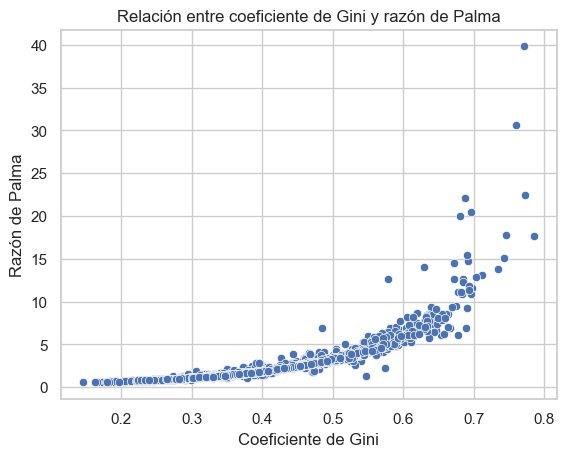

In [54]:
sns.scatterplot(data=datos_desigualdad, x='gini_reported', y='palma')
plt.title('Relación entre coeficiente de Gini y razón de Palma')
plt.xlabel('Coeficiente de Gini')
plt.ylabel('Razón de Palma')
plt.show()